## General example
This example covers some of the core functionalities of the toolbox.
### Outline
- Load a test dataset
- Preliminary analysis
 - Show summary
 - Show some plots
- Preprocess data
- Evaluate a classifier
- Show some model selection plots

In [2]:
import sys
sys.path.append("C:\\Users\\aartetxe\\ARKAITZ\\par-toolbox\\partb")
sys.path.append("C:\\Users\\aartetxe\\ARKAITZ\\par-toolbox")

In [3]:
# Dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from utility.preprocessing import PreProcessing

In [4]:
# Allow hot reload of modules
%load_ext autoreload
%autoreload 2
# Show plots within notebook
%matplotlib inline

In [64]:
# Load data
df = pd.read_csv('../data/readmission_example.csv', sep=';')

In [65]:
# Construct preprocessor
prepro = PreProcessing(df, 'OUTCOME')

# Calculate and set length of stay (LOS) 
prepro.set_los('HOSP_DATE', 'DISCHARGE_DATE')
prepro.set_first_diagnostic('FIRSTDIAG', 'HOSP_DATE')
prepro.set_age('DAY_OF_BIRTH', 'HOSP_DATE')

df.head()

,PATIENT_ID,HOSP_DATE,DISCHARGE_DATE,DAY_OF_BIRTH,SEX,SMOKE,LVEF,FIRSTDIAG,NEED_OXYGEN,UREA,CREATININE,SODIUM,POTASSIUM,HEMOGLOBIN,SINUS_RHYTHM,ATRIAL_FIBRILLATION,PACEMAKER_RHYTHM,OUTCOME,LOS,AGE
0,PATIENT001,22/02/2014,05/03/2014,01/01/1949,female,yes,20,0,0,45,0.94,139,5.30,15.3,1,0,0,readmitted,11.0,65.0
1,PATIENT002,14/03/2014,21/03/2014,01/01/1924,male,no,20,34,0,95,1.39,141,4.30,10.2,1,0,0,readmitted,7.0,90.0
2,PATIENT003,14/05/2014,16/05/2014,01/01/1947,male,yes,40,1,0,47,1.01,145,3.06,16.6,1,0,0,not-readmitted,2.0,67.0
3,PATIENT004,29/03/2014,09/04/2014,01/01/1928,male,no,25,18,0,50,1.13,145,2.94,14.0,0,0,1,readmitted,11.0,86.0
4,PATIENT005,NaN,NaN,01/01/1949,male,former,60,NaN,0,42,1.33,141,4.30,10.5,0,1,0,not-readmitted,NaN,NaN


In [66]:
# Encode strings
df['OUTCOME'] = map(lambda x: 1 if x=='readmitted' else 0, df['OUTCOME'])
df['SEX'] = map(lambda x: 1 if x=='male' else 0, df['SEX'])

def encode_smoke(x):
    if x == 'yes':
        return 2 # smoker
    elif x == 'no':
        return 0 # not smoker
    elif x == 'former':
        return 1 # former smoker
    else:
        return

df['SMOKE'] = map(encode_smoke, df['SMOKE'])

# Remove unnecesary data
del df['PATIENT_ID']
del df['HOSP_DATE']
del df['DISCHARGE_DATE']
del df['DAY_OF_BIRTH']

# Simple missing value imputation
df.fillna(0, inplace=True)

df.head()

,SEX,SMOKE,LVEF,FIRSTDIAG,NEED_OXYGEN,UREA,CREATININE,SODIUM,POTASSIUM,HEMOGLOBIN,SINUS_RHYTHM,ATRIAL_FIBRILLATION,PACEMAKER_RHYTHM,OUTCOME,LOS,AGE
0,0,2,20,0,0,45,0.94,139,5.30,15.3,1,0,0,1,11.0,65.0
1,1,0,20,34,0,95,1.39,141,4.30,10.2,1,0,0,1,7.0,90.0
2,1,2,40,1,0,47,1.01,145,3.06,16.6,1,0,0,0,2.0,67.0
3,1,0,25,18,0,50,1.13,145,2.94,14.0,0,0,1,1,11.0,86.0
4,1,1,60,0,0,42,1.33,141,4.30,10.5,0,1,0,0,0.0,0.0


In [67]:
# Split data and label
dataset = df.drop(['OUTCOME'], axis=1)
target = df['OUTCOME']
# Format dataset and label
X = dataset.as_matrix()
y = target.as_matrix().astype(int)

In [68]:
# Test a classifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression()

arr = []
for i in range(0,10):
    ema = cross_val_score(cls, X, y, cv=10, scoring='roc_auc')
    arr.append(np.mean(ema))

print "Mean AUC (standard deviation): %.2f (%.3f)" % (np.mean(arr), np.std(arr))

Mean AUC (standard deviation): 0.57 (0.000)


# Feature importance

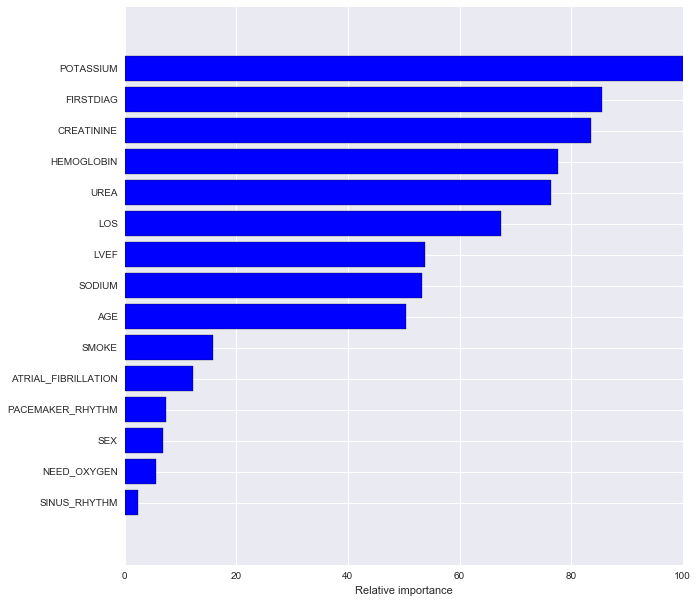

In [105]:
from partb.visualization import descriptive as viz

# We use feature importances reported by random forest
rf.fit(X, y)
feature_importance  = rf.feature_importances_

# Plot rank of relative importance
viz.plot_rank(dataset, feature_importance)

In [123]:
from partb.descriptive import features as fts

# Select the features
signif_data = fts.anova(df, "OUTCOME", alpha=0.1)


Feature		p-value

SEX		 0.3134
SMOKE		 0.2395
LVEF		 0.0471
FIRSTDIAG		 0.0000
NEED_OXYGEN		 0.9303
UREA		 0.0990
CREATININE		 0.2106
SODIUM		 0.0522
POTASSIUM		 0.2556
HEMOGLOBIN		 0.0661
SINUS_RHYTHM		 0.9480
ATRIAL_FIBRILLATION		 0.6295
PACEMAKER_RHYTHM		 0.6458
OUTCOME		 0.0209
LOS		 0.1014


,LVEF,FIRSTDIAG,UREA,SODIUM,HEMOGLOBIN,OUTCOME,OUTCOME
0,20,0,45,139,15.30,1,1
1,20,34,95,141,10.20,1,1
2,40,1,47,145,16.60,0,0
3,25,18,50,145,14.00,1,1
4,60,0,42,141,10.50,0,0
5,45,2,97,140,14.20,0,0
6,15,11,176,123,9.40,1,1
7,20,10,38,136,14.50,0,0
8,25,7,116,140,8.90,1,1
9,25,0,35,139,163.00,1,1
